# Import Libraries

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import goatools
from goatools.obo_parser import GODag

# Ploting Functions

In [2]:
def threshold_idx(values,thres):
    idx = []
    for i in range(len(values)):
        if values[i] > thres:
            idx.append(i)
    return idx

def plot_histogram(ax,values,xLabel,yLabel):
    # plotting
    n, bins, patches = ax.hist(values, 50,  facecolor='green', alpha=0.75)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    # plt.title(filename)
    # plt.axis([0, 1e+06, 0, 20])
    # ax.grid(True)
    
def plot_multiple(values1,labels1,values2,labels2,yLabel):
    fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
    plot_histogram(ax1,values1,labels1,yLabel)
    plot_histogram(ax2,values2,labels2,yLabel)
    fig.set_size_inches(17, 7, forward=True)

# Load GO Terms

In [3]:
def get_tissue_GO_terms(tissueGOFilename):
    # extract all relevant GO terms
    GOMap = {}
    # tissueGOFilename = '../data/BTO_GO.csv'
    inputFile = open(tissueGOFilename)
    atLine = 0
    skipLines = 2
    for line in inputFile:
        if atLine < skipLines:
            atLine += 1
            continue
        str_list = line.split(',')[1:]
        tissue = str_list[0]
        for term in str_list[1:]:
            if term == '' or term == '\r\n':
                continue
            else: 
                term = term.split('\r\n')[0] # to avoid end of string in the last 
                if term not in GOMap:
                    GOMap[term] = [tissue]    
                else:
                    GOMap[term].append(tissue)
                    # print tissue, term      
    inputFile.close()
    # print 'Number of tissues in BTO : ' + str(len(tissues))
    print 'Number of GO terms       : ' + str(len(GOMap))
    return GOMap

def get_handpicked_GO_terms(selectionFilename,tissueGOFilename):
    # extract the relevent tissue types
    tissues = {}
    # selectionFilename = '../data/Tissue_Name_Mappings.csv' # manually curated by Nico
    inputFile = open(selectionFilename)
    atLine = 0
    for line in inputFile:
        str_list = line.split(',')[1:]
        for term in str_list:
            if term == '' or term == '\r\n':
                continue
            else:
                term = term.split('\r\n')[0] # to avoid end of string in the last term
                tissues[term] = int(term.split('(')[1].split(')')[0])
    inputFile.close()

    # extract the relevant GO terms
    GOMap = {}
    # tissueGOFilename = '../data/BTO_GO.csv'
    inputFile = open(tissueGOFilename)
    atLine = 0
    skipLines = 2
    for line in inputFile:
        if atLine < skipLines:
            atLine += 1
            continue
        str_list = line.split(',')[1:]
        tissue = str_list[0]
        if tissue in tissues:
            for term in str_list[1:]:
                if term == '' or term == '\r\n':
                    continue
                else: 
                    term = term.split('\r\n')[0] # to avoid end of string in the last term
                    if term not in GOMap:
                        GOMap[term] = [tissue]    
                    else:
                        GOMap[term].append(tissue)
                        #print tissue, term
    inputFile.close()
    print 'Number of tissues in BTO : ' + str(len(tissues))
    print 'Number of GO terms       : ' + str(len(GOMap))
    return GOMap

In [4]:
from goatools.associations import read_ncbi_gene2go
from goatools.base import download_ncbi_associations

def map_entrez_to_ensembl(path):
    dict = {}
    file = open(path)
    for line in file:
        vals = line.split('\t')
        ens_gene_id = vals[0]
        entrez_id = vals[2]
        dict[entrez_id] = ens_gene_id

    file.close()
    return dict

def get_ensembl_ids(go_process_id, go_to_entrez_ids_human):
    # taxids=[9606] means select only human.
    # TODO: ask Marinka if we should use EXP code for evidence!!
    
    """, evidence_set='EXP'"""
    entrez_ids = go_to_entrez_ids_human[GO_PROCESS_ID]
    
    # ensembl_ids = []
    # for ent_id in entrez_ids:
    #    ensembl_ids.append(entrez_to_ensembl[str(ent_id)])
    # print("{N} GO terms associated with human NCBI Entrez GeneIDs".format(N=len(go_to_entrez_ids_human)))
    #return ensembl_ids
    return entrez_ids

def convert_geneids_and_print(geneids):
    for geneid in geneids: # geneids associated with cell-cycle
        nt = GeneID2nt_hsa.get(geneid, None)
        if nt is not None:
            print("{Symbol:<10} {desc}".format(
                    Symbol = nt.Symbol, 
                    desc = nt.description))

In [29]:
def add_all_children(obj, gos):
    """Return children of input gos plus input gos."""
    lst = []
    obo_dag = obj.obo_dag
    get_children = lambda go_obj: list(go_obj.get_all_children()) + [go_obj.id]
    for go_id in gos:
        go_obj = obo_dag[go_id]
        lst.extend(get_children(go_obj))
    return set(lst)

def add_all_parents(obj, gos):
    """Return children of input gos plus input gos."""
    lst = []
    obo_dag = obj.obo_dag
    
    get_parents = lambda go_obj: list(go_obj.get_all_parents()) + [go_obj.id]
    for go_id in gos:
        go_obj = obo_dag[go_id]
        lst.extend(get_parents(go_obj))
    return set(lst)

def get_parent_ids(obj,go_id):
    obo_dag = obj.obo_dag
    go_obj = obo_dag[go_id]
    parents_ids = [term.id for term in go_obj.parents]
    return set(parents_ids)

def get_description(obj,go_id):
    obo_dag = obj.obo_dag
    go_obj = obo_dag[go_id]
    return go_obj.name

def create_black_list_genes(srchhelp,entrez_to_ensembl,GO_PROCESS_ID):
    gos_all = add_all_children(srchhelp,[GO_PROCESS_ID])# get all descendents
    num_descendents = len(gos_all) - 1
    parent_set = get_parent_ids(srchhelp,GO_PROCESS_ID) # get direct parents
    num_parents = len(parent_set)
    gos_all = gos_all.union(parent_set) 
    # get all genes in this list
    entrez_ids = srchhelp.get_items(gos_all)
    num_genes = len(entrez_ids)
    print GO_PROCESS_ID
    print '\t# of desendents:', str(num_descendents),'\t# of parents:',str(num_parents)
    # convert geneids to ensemble IDs
    ensembl_ids = []
    for ent_id in entrez_ids:
        ensembl_ids.append(entrez_to_ensembl[str(ent_id)])
    # print("{N} GO terms associated with human NCBI Entrez GeneIDs".format(N=len(go_to_entrez_ids_human)))
    #return ensembl_ids
    print '\t# of genes before conversion:', str(num_genes), '\t# of genes after conversion:',str(len(ensembl_ids))
    return ensembl_ids

# Load Information From Externel Databases


### Specify relevant path names

In [6]:
obo_file = '/Users/jjzhu/Documents/GTEx/local_data/go-basic.obo'
gene2go = '/Users/jjzhu/Documents/GTEx/local_data/gene2go.txt' # gene2go = download_ncbi_associations()
tissueGOFilename = '../data/BTO_GO.csv'
biomart_file_path = '../data/biomart_ensembl_to_entrez.txt'

### Load the Gene and GO Associations

In [7]:
assert os.path.exists(gene2go), "file %s not found!" % gene2go
go_to_entrez_ids_human = read_ncbi_gene2go(gene2go, taxids=[9606], go2geneids=True)

### Load the GO DAG data structure with associations

In [8]:
from goatools.go_search import GoSearch
assert os.path.exists(obo_file), "file %s not found!" % obo_file
srchhelp = GoSearch(obo_file, go2items=go_to_entrez_ids_human)

load obo file /Users/jjzhu/Documents/GTEx/local_data/go-basic.obo
46545

/Users/jjzhu/Documents/GTEx/local_data/go-basic.obo: format-version(1.2) data-version(releases/2016-04-30)


 nodes imported


### Load GO terms mapped to specific tissues 

In [9]:
assert os.path.exists(tissueGOFilename), "file %s not found!" % tissueGOFilename
GOMap = get_tissue_GO_terms(tissueGOFilename)

Number of GO terms       : 6172


### Load Gene ID covnversion maps

In [10]:
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GeneID2nt as GeneID2nt_hsa # Gene Annotation
assert os.path.exists(biomart_file_path), "file %s not found!" % biomart_file_path
entrez_to_ensembl = map_entrez_to_ensembl(biomart_file_path)

# Summarize the number of Associated Genes

Number of GO terms with at least 30 terms is 477


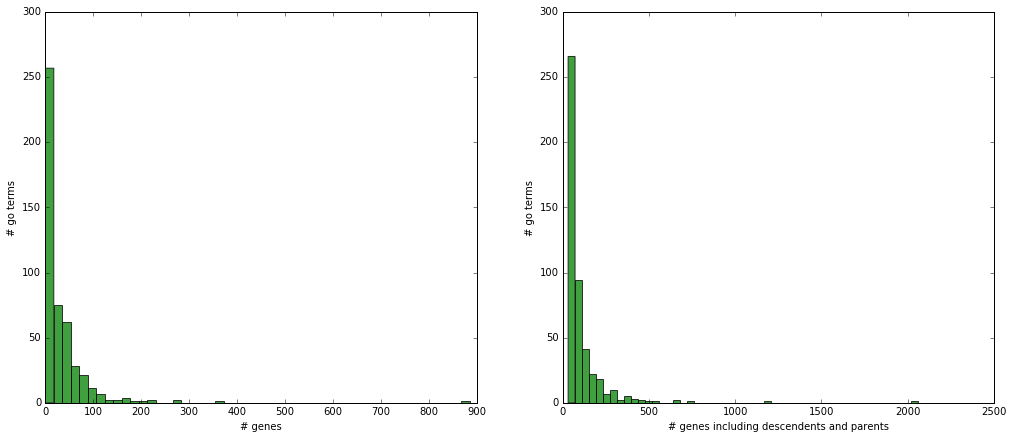

In [34]:
minGeneThreshold = 30

geneCounts = []
geneAllChildrenCounts = []

for key in GOMap:
    GO_PROCESS_ID = key  # Biological Process ID in Gene Ontology
    
    # SINGLE GO TERM
    geneids = srchhelp.get_items([GO_PROCESS_ID])
    num_ensemble_ids = len(geneids)
    geneCounts.append(num_ensemble_ids)
    # if num_ensemble_ids > 10:
    #   GO_NAME = srchhelp.obo_dag[GO_PROCESS_ID].name
    #    print GO_PROCESS_ID, ':' ,GO_NAME
    #    convert_geneids_and_print(geneids)
    #    break
    
    # GO TERM WITH DESCENDENTS/PARENTS
    gos_all = add_all_children(srchhelp,[GO_PROCESS_ID]) # get all desendents      
    # gos_all = gos_all.union(get_parent_ids(srchhelp,GO_PROCESS_ID)) # get direct parents
    
    geneids = srchhelp.get_items(gos_all)
    num_ensemble_children_ids = len(geneids)
    geneAllChildrenCounts.append(num_ensemble_children_ids)  
    
    # print key + ': # of Ensemble IDs: ', num_ensemble_ids, '\twith children: ', num_ensemble_children_ids
    # print '\t# of desendents', str(len(gos_w_children)), ',\t# of parents', str(len(go_parent))

idx = threshold_idx(geneAllChildrenCounts,minGeneThreshold) 
print 'Number of GO terms with at least',str(minGeneThreshold),'terms is', str(len(idx))
gc1 = [geneCounts[i] for i in idx]
gc2 = [geneAllChildrenCounts[i] for i in idx]
plot_multiple(gc1,'# genes',gc2,'# genes including descendents and parents','# go terms')


# Create Black List

In [33]:
for key in GOMap:
    GO_PROCESS_ID = key  # Biological Process ID in Gene Ontology
    black_list_genes = create_black_list_genes(srchhelp,entrez_to_ensembl,GO_PROCESS_ID)
    print black_list_genes
    break
 

GO:0030852
	# of desendents: 11 	# of parents: 1
	# of genes before conversion: 17 	# of genes after conversion: 17
['ENSG00000005483', 'ENSG00000139842', 'ENSG00000159216', 'ENSG00000142611', 'ENSG00000159189', 'ENSG00000173334', 'ENSG00000113525', 'ENSG00000131507', 'ENSG00000138795', 'ENSG00000281614', 'ENSG00000088992', 'ENSG00000130584', 'ENSG00000147162', 'ENSG00000181092', 'ENSG00000143575', 'ENSG00000131759', 'ENSG00000180353']
